# Gene and reaction knockouts
This script aims to conduct knockout studies on all models and visualize / report those for the thesis.

*Author: Famke Baeuerle*

In [43]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import refinegems as rg
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from PARAMS import *
from matplotlib import transforms as tf

REAC_URL = 'http://bigg.ucsd.edu/api/v2/universal/reactions/'
METAB_URL = 'http://bigg.ucsd.edu/api/v2/universal/metabolites/'

%matplotlib inline

### Workflow to access essential genes per model

We load the model we are working with via cobra as `model` and via libSBML as `MODEL` to be used with the functions below.

In [80]:
modelname = 'Cstr_KC-Na-01'
modelpath = '../../models/' + modelname + '.xml'
model_lib = rg.io.load_model_libsbml(modelpath)
model = rg.io.load_model_cobra(modelpath)

We define some functions that can be used with the pandas `apply` function.

In [81]:
def set_to_id(id):
    return list(id)[0]

def get_gene_name(gene, model):
    """Extract gene name to add to table with essential genes"""
    gene = 'G_' + gene
    return model.getPlugin(0).getGeneProduct(gene).getName()

def get_associated_reactions(gene, model):
    """Extract associated reactions with a specific gene"""
    gene = 'G_' + gene
    reacs = model.getListOfReactions()
    gpr_list = []
    for reac in reacs:
        gpa = reac.getPlugin(0).getGeneProductAssociation()
        if gpa is not None:
            gpr = gpa.getAssociation()
            if gpr.isGeneProductRef():
                if gpr.getGeneProduct() == gene:
                    if reac.getId() not in gpr_list:
                        gpr_list.append(reac.getId())
            elif gpr.isFbcOr():
                gpr_sub = gpr.getListOfAssociations()
                for gp in gpr_sub:
                    if gp.isFbcAnd():
                        gpr_and = gp.getListOfAssociations()
                        for gpand in gpr_and:
                            if gpand.getGeneProduct() == gene:
                                if reac.getId() not in gpr_list:
                                    gpr_list.append(reac.getId())
                    else:
                        if gp.getGeneProduct() == gene:
                            if reac.getId() not in gpr_list:
                                gpr_list.append(reac.getId())
    return gpr_list

def get_reaction_name(id):
    """Extract information on reaction based on given ID to add to overview table"""
    id = id[2:]
    reac = requests.get(REAC_URL + id).json()
    rea_str = reac['reaction_string']
    rea_str = rea_str.replace('&#8652;', '\N{Rightwards Harpoon Over Leftwards Harpoon}') # $\rightleftharpoons$ for latex
    name = reac['name']
    return name, rea_str


def get_reaction_sbo_per_mod(id, model):
    """Extract SBO term label (human readable) when given a reaction id, and the corresponding model"""
    try:
        sbo = model.getReaction(id).getSBOTerm()
        label = rg.io.search_sbo_label(sbo)
        return label
    except:
        return ' '

Now we conduct the single gene deletion with COBRApy.

In [82]:
deletion_results = single_gene_deletion(model)
deletion_results['ids'] = deletion_results['ids'].apply(set_to_id)

We keep only genes as essential were the growth rate was below 1 (this is an easy cut-off and as can be seen in the following table these growth values are mostly much smaller than 1 and not say 0.95).

In [83]:
essential = deletion_results[deletion_results['growth'] < 1]

Now we map the gene (protein) names based on the `fbc:name` tag in our model.

In [84]:
essential.loc[:,'name']= essential['ids'].apply(get_gene_name, model=model_lib).values

/usr/local/anaconda3/envs/rg/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/anaconda3/envs/rg/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


And we add the reactions associated with the gene product to the dataframe.

In [85]:
essential.loc[:,'reaction'] = essential['ids'].apply(get_associated_reactions, model=model_lib).values
essential = essential.explode('reaction')

In [86]:
essential = essential.reset_index(drop=True)
essential.loc[:,'class'] = essential['reaction'].apply(get_reaction_sbo_per_mod, model=model_lib).values

And we can save this to a csv, then conduct the same analysis for the other models and afterwards compare the identified reactions.

In [87]:
essential.to_csv('../../analysis/essentiality/' + modelname + '_ess_genes.csv', index = False)

### Comparison of essential genes for all models

We load all essential genes dataframes into one dataframe and then check which reactions are essential to all models.

In [89]:
modelnames = ['TS', '1197', '1115', '1116', 'KC-Na-01']
reacs = {name: pd.read_csv('../../analysis/essentiality/Cstr_' + name + '_ess_genes.csv')['reaction'] for name in modelnames}

In [90]:
reacs_df = pd.DataFrame(reacs)
overlap = list(set(reacs_df['TS']).intersection(set(reacs_df['1197'])).intersection(set(reacs_df['1115'])).intersection(set(reacs_df['1116'])).intersection(set(reacs_df['KC-Na-01'])))

With this list we can now extract more information about those reactions, like their name, their classification (via SBO term), etc.

In [91]:
info = pd.DataFrame()
info['ID'] = overlap
info.dropna(inplace=True)
info[['Name', 'Reaction']] = info['ID'].apply(get_reaction_name).tolist()
info.loc[:,'Class'] = info['ID'].apply(get_reaction_sbo_per_mod, model=model_lib)
info.sort_values('Class')

,ID,Name,Reaction,Class
20,R_UGMDDS,UDP-N-acetylmuramoyl-L-alanyl-D-glutamyl-meso-...,alaala_c + atp_c + ugmd_c ⇌ adp_c + h_c + pi_c...,biochemical reaction
6,R_PLPS,Pyridoxal-5-phosphate synthase,g3p_c + gln__L_c + r5p_c ⇌ glu__L_c + h_c + 3....,biochemical reaction
27,R_PPNCL3,4'-Phosphopantothenate:L-cysteine ligase,4ppan_c + atp_c + cys__L_c ⇌ 4ppcys_c + amp_c ...,biochemical reaction
19,R_CHORS,Chorismate synthase,3psme_c ⇌ chor_c + pi_c,cleavage
12,R_MECDPS,"2-C-methyl-D-erythritol 2,4-cyclodiphosphate s...",2p4c2me_c ⇌ 2mecdp_c + cmp_c,cleavage
3,R_DHNAOT,"1,4-dihydroxy-2-naphthoate octaprenyltransferase",dhna_c + octdp_c ⇌ 2dmmq8_c + co2_c + h_c + ppi_c,decarboxylation
13,R_PPCDC,Phosphopantothenoylcysteine decarboxylase,4ppcys_c + h_c ⇌ co2_c + pan4p_c,decarboxylation
31,R_UAGPT3,UDP-N-acetylglucosamine-N-acetylmuramyl-(penta...,uacgam_c + uagmda_c ⇌ h_c + uaagmda_c + udp_c,glycosylation
22,R_ICHORS,Isochorismate synthase,chor_c ⇌ ichor_c,isomerisation
2,R_MGt5,Magnesium transport in/out via permease (no H+),mg2_c ⇌ mg2_e,passive transport


To include the table in the thesis it can be converted to tech.

In [92]:
with pd.option_context("max_colwidth", 100):
    print(info.sort_values('Class').to_latex(index=False))

\begin{tabular}{llll}
\toprule
        ID &                                                                                                 Name &                                                                Reaction &                        Class \\
\midrule
  R\_UGMDDS &      UDP-N-acetylmuramoyl-L-alanyl-D-glutamyl-meso-2,6-diaminopimeloyl-D-alanyl-D-alanine synthetase &                alaala\_c + atp\_c + ugmd\_c ⇌ adp\_c + h\_c + pi\_c + ugmda\_c &         biochemical reaction \\
    R\_PLPS &                                                                       Pyridoxal-5-phosphate synthase & g3p\_c + gln\_\_L\_c + r5p\_c ⇌ glu\_\_L\_c + h\_c + 3.0 h2o\_c + pi\_c + pydx5p\_c &         biochemical reaction \\
  R\_PPNCL3 &                                                             4'-Phosphopantothenate:L-cysteine ligase &             4ppan\_c + atp\_c + cys\_\_L\_c ⇌ 4ppcys\_c + amp\_c + h\_c + ppi\_c &         biochemical reaction \\
   R\_CHORS &                            

### Visualization of gene essentiality


The goal is to visualize the number of essential genes and reactions per strain.

In [93]:
# genes
dfs = {name: pd.read_csv('../../analysis/essentiality/Cstr_' + name + '_ess_genes.csv')['ids'] for name in modelnames}
genes_df = pd.DataFrame(dfs)
for modelname in modelnames:
    genes_df[modelname] = genes_df[modelname].drop_duplicates()
genes_df = genes_df.apply(lambda x: pd.Series(x.dropna().values))
genes_df.head()

,TS,1197,1115,1116,KC-Na-01
0,lcl_CP066290_1_prot_QQE54086_1_1140,lcl_CP069514_1_prot_QRP20144_1_1205,lcl_CP068158_1_prot_QQU78084_1_1217,lcl_CP068157_1_prot_QQU80617_1_277,WP_086890747_1
1,lcl_CP066290_1_prot_QQE53442_1_400,lcl_CP069514_1_prot_QRP18063_1_1741,lcl_CP068158_1_prot_QQU76704_1_2271,lcl_CP068157_1_prot_QQU79012_1_1873,WP_086891472_1
2,lcl_CP066290_1_prot_QQE53417_1_372,lcl_CP069514_1_prot_QRP18222_1_1921,lcl_CP068158_1_prot_QQU77526_1_568,lcl_CP068157_1_prot_QQU79457_1_2373,WP_086892492_1
3,lcl_CP066290_1_prot_QQE53455_1_416,lcl_CP069514_1_prot_QRP18231_1_1930,lcl_CP068158_1_prot_QQU76600_1_2146,lcl_CP068157_1_prot_QQU79669_1_209,WP_086891735_1
4,lcl_CP066290_1_prot_QQE53057_1_2641,lcl_CP069514_1_prot_QRP18600_1_2349,lcl_CP068158_1_prot_QQU76985_1_2585,lcl_CP068157_1_prot_QQU80448_1_1078,WP_086892115_1


In [94]:
# reactions
dfs = {name: pd.read_csv('../../analysis/essentiality/Cstr_' + name + '_ess_genes.csv')['reaction'] for name in modelnames}
reac_df = pd.DataFrame(dfs)
for modelname in modelnames:
    reac_df[modelname] = reac_df[modelname].drop_duplicates()
reac_df = reac_df.apply(lambda x: pd.Series(x.dropna().values))
reac_df.head()

,TS,1197,1115,1116,KC-Na-01
0,R_NDPK1,R_DHFS,R_ASAD,R_UDCPDP,R_PRAGSr
1,R_NDPK2,R_SHKK,R_UAAGDS,R_MECDPS,R_PTPATi
2,R_NDPK3,R_RBFSa,R_ASPO5,R_DXPRIi,R_SUCBZS
3,R_NDPK4,R_METAT,R_ASPO6,R_NADK,R_CDPMEK
4,R_NDPK5,R_ASPO5,R_IPDPUDCT,R_ADK1,R_DHNAOT


In [95]:
numbers = pd.DataFrame(index=modelnames)
numbers['essential genes'] = [genes_df['TS'].dropna().size, genes_df['1197'].dropna().size, genes_df['1115'].dropna().size, genes_df['1116'].dropna().size, genes_df['KC-Na-01'].dropna().size]
numbers['essential reactions'] = [reac_df['TS'].dropna().size, reac_df['1197'].dropna().size, reac_df['1115'].dropna().size, reac_df['1116'].dropna().size, reac_df['KC-Na-01'].dropna().size]
numbers

,essential genes,essential reactions
TS,54,76
1197,62,135
1115,65,118
1116,64,105
KC-Na-01,63,125


We need standard sizes to calculate the percentage of these essential genes / reactions.

In [96]:
models = {name: list(rg.investigate.initial_analysis(rg.io.load_model_libsbml('../../models/Cstr_' + name + '.xml'))) for name in modelnames}
numbers['total genes'] = [models['TS'][3], models['1197'][3], models['1115'][3], models['1116'][3], models['KC-Na-01'][3]]
numbers['total reactions'] = [models['TS'][1], models['1197'][1], models['1115'][1], models['1116'][1], models['KC-Na-01'][1]]

Now we can calculate the percentages.

In [97]:
numbers['percentage genes'] = (numbers['essential genes'] / numbers['total genes']) * 100
numbers['percentage reactions'] = (numbers['essential reactions'] / numbers['total reactions']) * 100
numbers = numbers.rename({'KC-Na-01': 'KC'}, axis=0)
numbers

,essential genes,essential reactions,total genes,total reactions,percentage genes,percentage reactions
TS,54,76,771,2005,7.003891,3.790524
1197,62,135,755,1677,8.211921,8.050089
1115,65,118,762,1754,8.530184,6.727480
1116,64,105,754,1792,8.488064,5.859375
KC,63,125,719,1544,8.762170,8.095855


And now we can plot both the absolute number of essential genes / reactions as well as the corresponding percentage of genes / reactions in one plot.

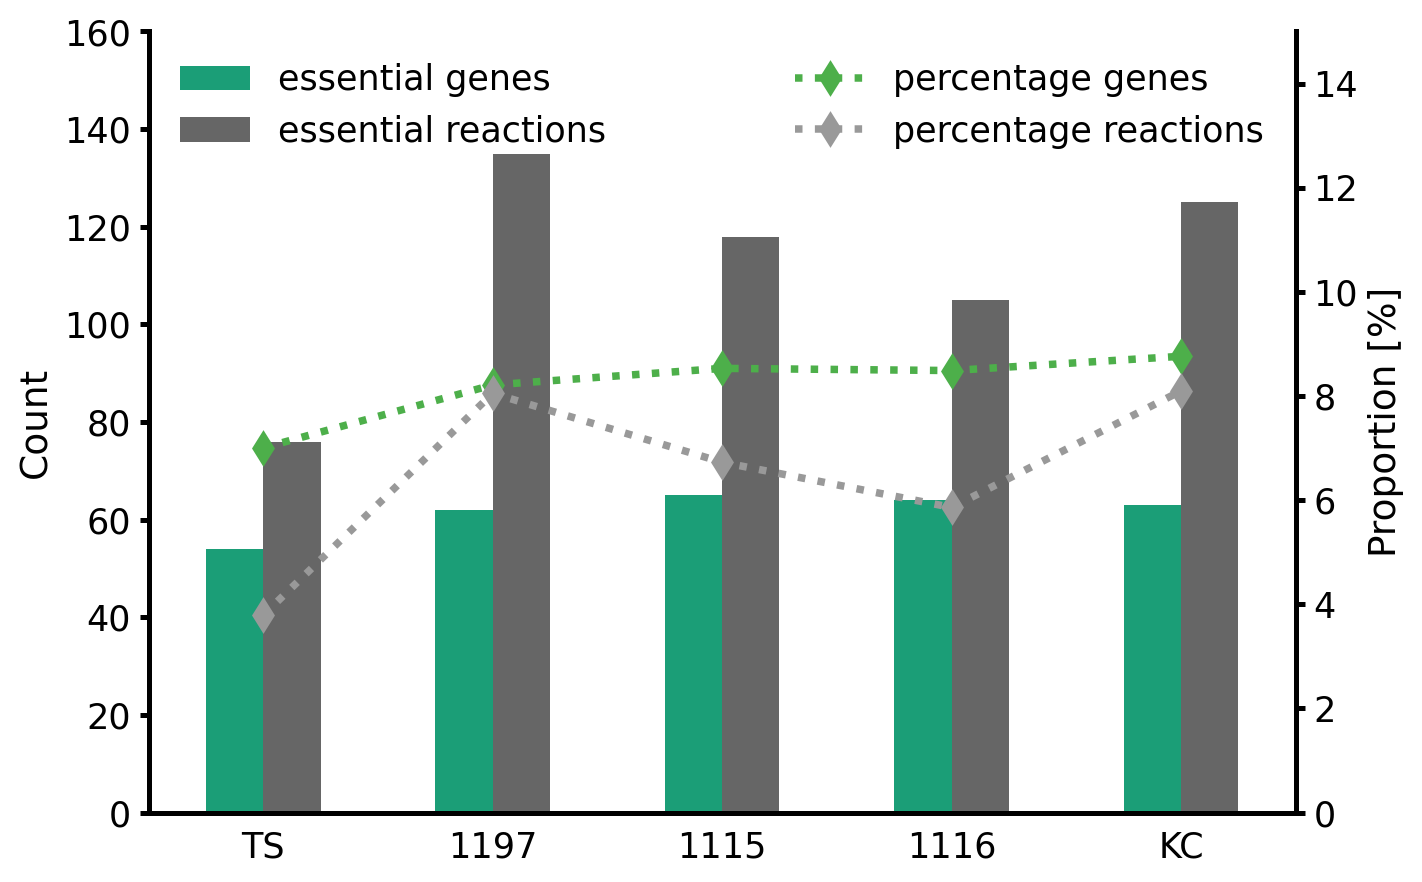

In [98]:
with plt.rc_context({"axes.spines.right" : True}):
    ax = numbers.plot.bar(y=['essential genes', 'essential reactions'], figsize=(8, 5), cmap='Dark2')
    numbers.plot(y=['percentage genes', 'percentage reactions'], ax=ax, use_index=False, linestyle=':', secondary_y=True, marker='d', color=[cb[2], cb[6]], linewidth=3, markersize=9)
    ax.right_ax.set_ylabel('Proportion [%]', fontsize=15)
    ax.right_ax.legend()
    ax.legend(title=False, loc='upper left')
    ax.right_ax.set_ylim([0, 15])
    ax.set_ylim([0,160])
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.set_ylabel('Count', fontsize=15)
    plt.tight_layout()
    plt.savefig('../../analysis/essentiality/essential_genes_stats.png')

### Visualization of reaction class distribution

Another visualization is the distribution of reaction classes via SBO terms, similar to the visualization done for the whole reactome. We do this as stacked bar charts so that the models stay distinguishable. We take the reactions dataframe and replace the reaction id with the corresponding SBO term class. Then the occurences are counted to be visualized.

In [99]:
sbos_df = pd.DataFrame({name: reac_df[name].dropna().apply(get_reaction_sbo_per_mod, model=rg.io.load_model_libsbml('../../models/Cstr_' + name + '.xml')) for name in modelnames})
sbos_num = pd.DataFrame({name: sbos_df[name].str.get_dummies().sum().to_dict() for name in modelnames}).replace({np.nan: 0})
sbos_num = sbos_num.rename({'KC-Na-01': 'KC'}, axis=1)
sbos_num

,TS,1197,1115,1116,KC
active transport,2.0,0.0,0.0,0.0,0.0
biochemical or transport reaction,2.0,2.0,2.0,2.0,0.0
biochemical reaction,17.0,34.0,27.0,28.0,27.0
cleavage,3.0,10.0,7.0,8.0,8.0
decarboxylation,4.0,4.0,6.0,4.0,3.0
glycosylation,4.0,4.0,4.0,2.0,3.0
isomerisation,4.0,3.0,5.0,4.0,3.0
passive transport,2.0,20.0,2.0,2.0,18.0
phosphorylation,18.0,18.0,18.0,17.0,29.0
redox reaction,4.0,18.0,26.0,18.0,12.0


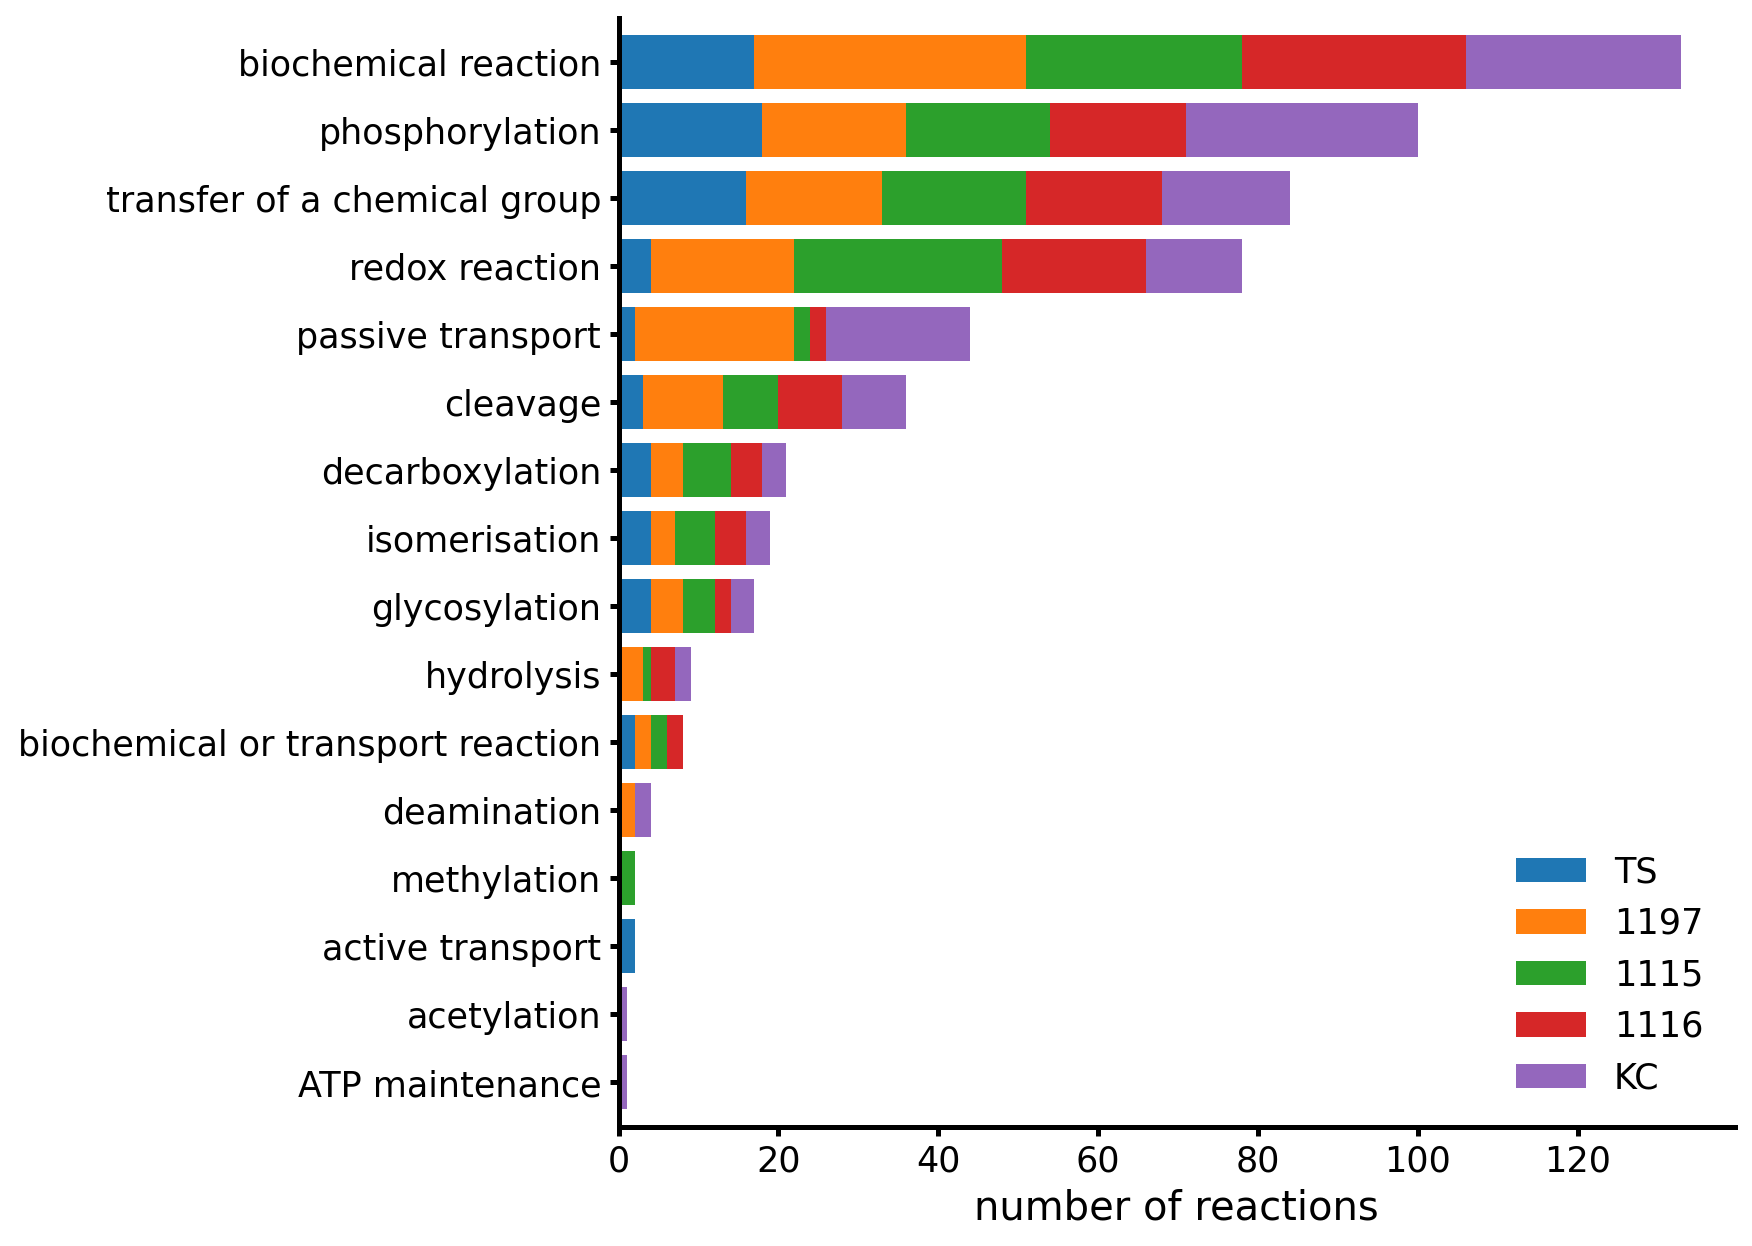

In [100]:
plt.close('all')
sbos_num.loc[:,'Row_Total'] = sbos_num.sum(numeric_only=True, axis=1)
sbos_num = sbos_num.sort_values(by='Row_Total')
sbos_num.drop('Row_Total', axis=1).plot.barh(stacked=True, width=.8, figsize=(8,8))
plt.legend(loc='lower right')
plt.ylabel('')
plt.xlabel('number of reactions', fontsize=16)
plt.savefig('../../analysis/essentiality/essential_reaction_distribution.png', bbox_inches='tight')